# Testing out some distributions in Pyro

- toc: true 
- badges: true
- comments: true
- author: Nipun Batra
- categories: [ML]

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
import pandas as pd
import seaborn as sns
import torch

sns.reset_defaults()
sns.set_context(context="talk", font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format='retina'

#### Univariate normal

In [96]:
uv_normal = dist.Normal(loc=1., scale=1.)

In [97]:
samples = uv_normal.sample(sample_shape=[1000])

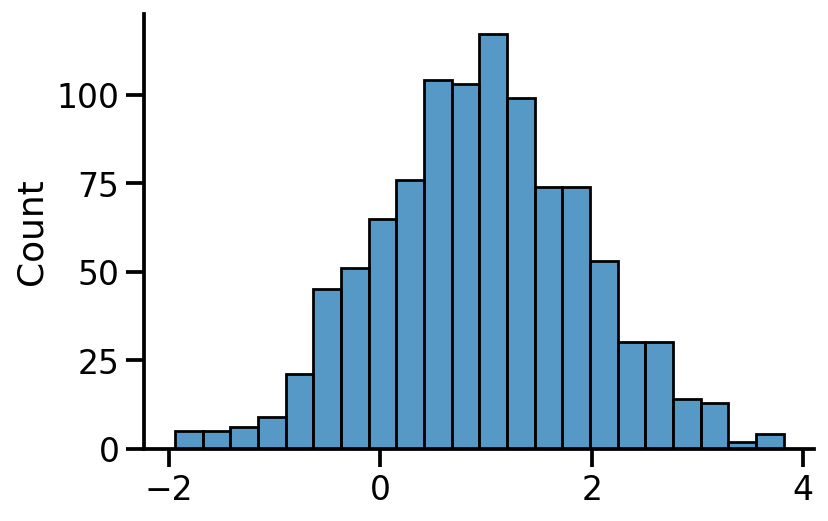

In [98]:
sns.histplot(samples)
sns.despine()

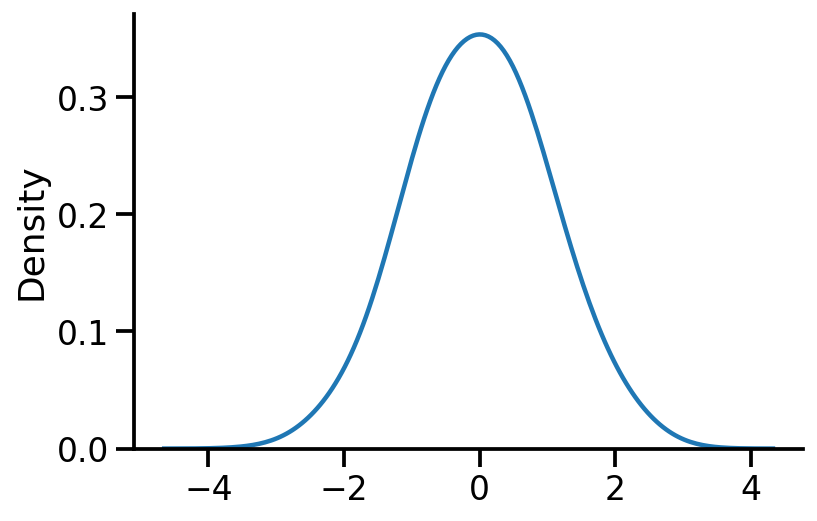

In [33]:
sns.kdeplot(samples, bw_adjust=2)
sns.despine()

In [34]:
uv_normal_dict_mean = {x: dist.Normal(loc=x, scale=1.0) for x in [-2, -1, 0, 1, 2]}

In [35]:
uv_normal_dict_mean_samples = pd.DataFrame(
    {x: uv_normal_dict_mean[x].sample([10000]) for x in uv_normal_dict_mean}
)

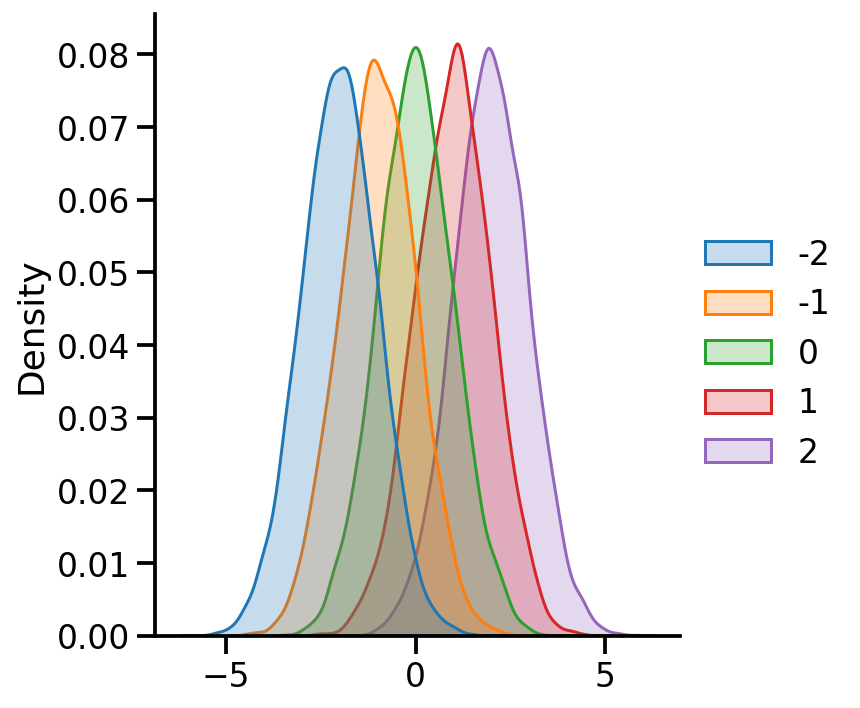

In [36]:
sns.displot(uv_normal_dict_mean_samples, kind="kde", fill=True)

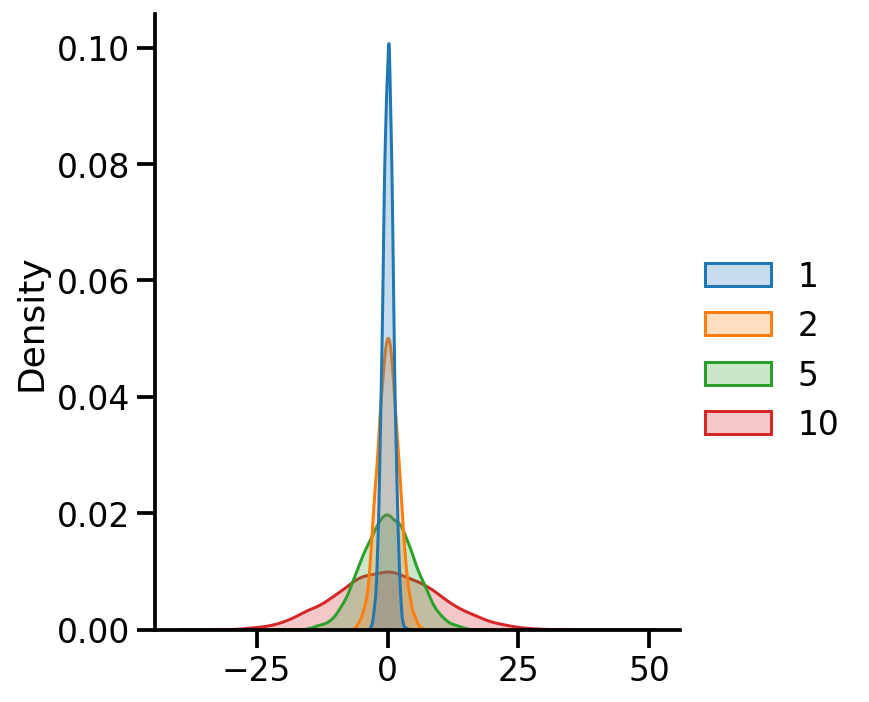

In [101]:
var_dfs = pd.DataFrame(
    tfd.Normal(loc=[0., 0., 0., 0.],
               scale=[1., 2., 5., 10.]).sample(10000).numpy())
var_dfs.columns = [1, 2, 5, 10]
sns.displot(var_dfs, kind='kde', fill=True)


In [103]:
tfd.Normal(loc=[0., 0., 0., 0.],
               scale=[1., 2., 5., 10.])

<tfp.distributions.Normal 'Normal' batch_shape=[4] event_shape=[] dtype=float32>

In [38]:
uv_normal.log_prob(torch.tensor([0.5, 0.2]))

tensor([-1.0439, -0.9389])

In [47]:
pdf_05.numpy()[0], log_pdf_05

(0.35206532, tensor([-1.0439]))

Text(0.5, 1.0, 'Density at x = 0.5 is 0.35\n Logprob at x = 0.5 is -1.04')

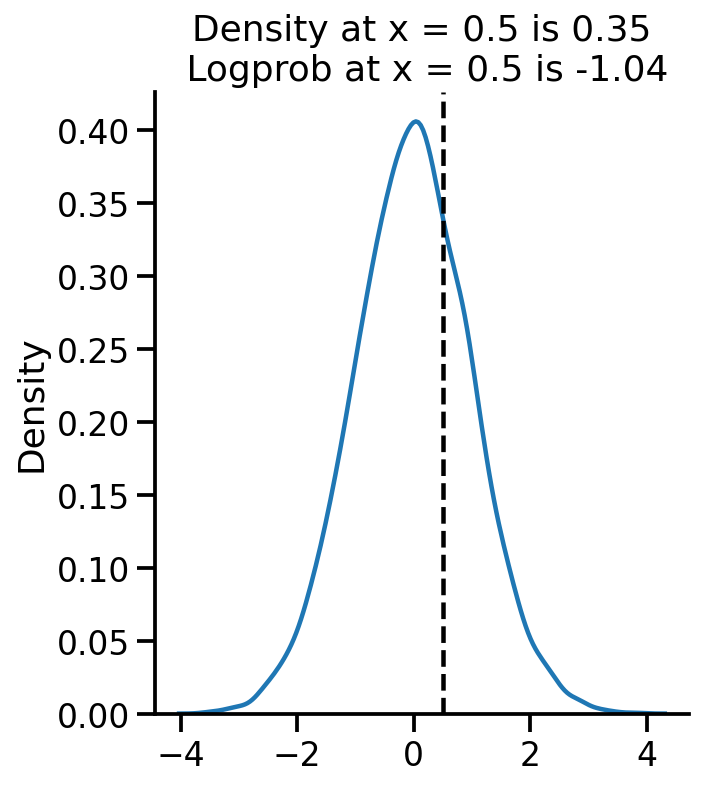

In [48]:
samples = uv_normal.sample([10000])
sns.displot(samples, kind="kde")
plt.axvline(0.5, color="k", linestyle="--")
log_pdf_05 = uv_normal.log_prob(torch.Tensor([0.5]))


pdf_05 = torch.exp(log_pdf_05)


plt.title(
    "Density at x = 0.5 is {:.2f}\n Logprob at x = 0.5 is {:.2f}".format(
        pdf_05.numpy()[0], log_pdf_05.numpy()[0]
    )
)

#### Learning parameters

Let us generate some normally distributed data and see if we can `learn` the mean.

In [49]:
train_data = uv_normal.sample([10000])

In [50]:
uv_normal.loc, uv_normal.scale

(tensor(0.), tensor(1.))

In [73]:
loc

tensor(0.1000, requires_grad=True)

In [74]:
adam = pyro.optim.Adam({"lr": 0.02})

In [75]:
adam

In [95]:
loc

tensor(0.1000, grad_fn=<SubBackward0>)

In [80]:
loc.grad

tensor(800.3969)

In [81]:
def original_model(data):
    loc = pyro.param("loc", init_tensor=torch.tensor(0.1))
    to_train = dist.Normal(loc=loc, scale=1.0)
    with pyro.plate("data", data.size(0)):
        pyro.sample("obs", dist.Bernoulli(f), obs=data)

In [82]:
loc

tensor(0.0200, grad_fn=<SubBackward0>)

In [94]:
torch.mean(train_data), torch.var(train_data)

(tensor(0.0200), tensor(0.9850))

In [99]:
pyro.clear_param_store()
loc = pyro.param("loc", init_tensor=torch.tensor(0.1))
for i in range(10):
    to_train = dist.Normal(loc=loc, scale=1.0)
    loss = -torch.mean(to_train.log_prob(train_data))
    
    loss.backward()
    print(to_train, loss, loc, loc.grad)
    loc = loc - 0.00001*loc.grad
    

Normal(loc: 0.10000000149011612, scale: 1.0) tensor(1.4146, grad_fn=<NegBackward0>) tensor(0.1000, requires_grad=True) tensor(0.0800)
Normal(loc: 0.09999920427799225, scale: 1.0) tensor(1.4146, grad_fn=<NegBackward0>) tensor(0.1000, grad_fn=<SubBackward0>) None


/Users/nipun/miniforge3/lib/python3.9/site-packages/torch/_tensor.py:1013: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1640812094853/work/build/aten/src/ATen/core/TensorBody.h:417.)
  return self._grad


TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

In [85]:
loc, loc.grad

/Users/nipun/miniforge3/lib/python3.9/site-packages/torch/_tensor.py:1013: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1640812094853/work/build/aten/src/ATen/core/TensorBody.h:417.)
  return self._grad


(tensor(-0.0601, grad_fn=<SubBackward0>), None)

In [121]:
losses = {}
for i in torch.linspace(-1.0, 1.0, 100):
    losses[i.item()] = -torch.sum(dist.Normal(loc=i, scale=1.0).log_prob(train_data)).item()

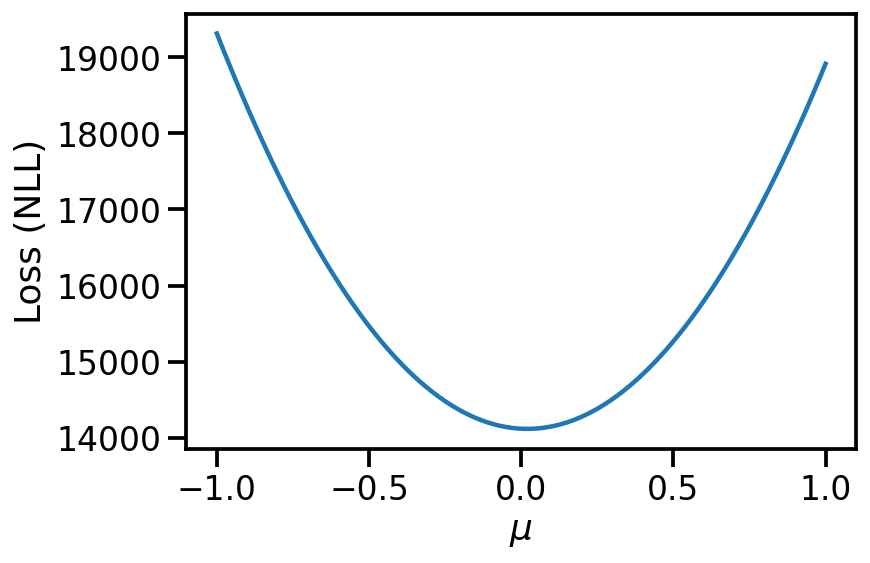

In [127]:
import pandas as pd
pd.Series(losses).plot(xlabel=r"$\mu$", ylabel="Loss (NLL)")
plt.savefig("/Users/nipun/Desktop/loss-pyro.png", bbox_inches="tight")

In [104]:
-torch.sum(dist.Normal(loc=0.5, scale=1.0).log_prob(train_data))

tensor(15266.1133)

In [105]:
-torch.sum(dist.Normal(loc=1.0, scale=1.0).log_prob(train_data))

tensor(18916.3125)

In [106]:
-torch.sum(dist.Normal(loc=0.0, scale=1.0).log_prob(train_data))

tensor(14115.9141)

In [107]:
-torch.sum(dist.Normal(loc=0.02, scale=1.0).log_prob(train_data))

tensor(14113.9229)

In [108]:
locs = torch.linspace(-1.0, 1.0, 100)

In [110]:
-torch.sum(dist.Normal(loc=locs, scale=1.0).log_prob(train_data))

ValueError: Value is not broadcastable with batch_shape+event_shape: torch.Size([10000]) vs torch.Size([100]).